In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv('data/df_regression.csv')

In [3]:
# 1. Definizione delle colonne da escludere
colonne_da_escludere = [
    'id_istat', 'id_comune', 'Provincia', 'Regione', 
    'Ripartizione Geografica', 'id_catastale', 'Codice regione', 
    'Capoluogo_enc', 'Codice comuni', 'id_univoco'
]


In [4]:
# 2. Definizione delle variabili target
variabili_target = [
    'Costo Minimo alla Vendita', 'Costo Massimo alla Vendita', 
    'Media Costo alla Vendita', 'Costo Minimo alla Locazione', 
    'Costo Massimo alla Locazione', 'Media Costo alla Locazione'
]

# Variabile target specifica per questo modello
target = 'Media Costo alla Locazione'


In [5]:
# 3. Preparazione dei dati
def prepara_dati(df):
    # Rimuoviamo le righe con valori mancanti nella variabile target
    df_clean = df.dropna(subset=[target])
    
    # Otteniamo tutte le colonne tranne quelle da escludere e le variabili target
    all_columns = set(df.columns)
    excluded_columns = set(colonne_da_escludere + variabili_target)
    feature_cols = list(all_columns - excluded_columns)
    
    # Manteniamo solo le colonne numeriche tra le feature selezionate
    numeric_feature_cols = [col for col in feature_cols if pd.api.types.is_numeric_dtype(df_clean[col])]
    
    # Gestiamo i valori mancanti nelle features
    df_clean = df_clean.dropna(subset=numeric_feature_cols)
    # In alternativa si potrebbe impiegare un'imputazione: df_clean[numeric_feature_cols] = df_clean[numeric_feature_cols].fillna(df_clean[numeric_feature_cols].mean())
    
    # Selezioniamo solo le colonne necessarie per l'analisi
    X = df_clean[numeric_feature_cols].copy()
    
    # Convertiamo tutte le colonne boolean in int (0/1)
    for col in X.select_dtypes(include=['bool']).columns:
        X[col] = X[col].astype(int)
    y = df_clean[target]
    
    return X, y, numeric_feature_cols


In [6]:
# 4. Funzione per calcolare il VIF (Variance Inflation Factor)
def calcola_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variabile"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values("VIF", ascending=False)


In [7]:
# 5. Implementazione della regressione stepwise backward
def stepwise_backward(X, y, soglia_p=0.05):
    '''
    Implementa una regressione stepwise backward basata sul p-value.
    Rimuove iterativamente le variabili con p-value maggiore della soglia.
    '''
    selected_features = list(X.columns)

    # Ensure all columns are numeric (convert bool to int)
    X_numeric = X.copy()
    for col in X_numeric.select_dtypes(include=['bool']).columns:
        X_numeric[col] = X_numeric[col].astype(int)

    while True:
        # Aggiungiamo una costante per l'intercetta
        X_with_const = sm.add_constant(X_numeric[selected_features])

        # Adattiamo il modello
        model = sm.OLS(y, X_with_const).fit()

        # Troviamo la variabile con il p-value massimo
        p_values = model.pvalues.iloc[1:]  # Saltiamo la costante
        max_p_value = p_values.max()

        # Se il p-value massimo è maggiore della soglia, rimuoviamo la variabile
        if max_p_value > soglia_p:
            max_p_feature = p_values.idxmax()
            selected_features.remove(max_p_feature)
            print(f"Rimossa variabile {max_p_feature} con p-value {max_p_value:.4f}")
        else:
            break

        # Se non rimangono più variabili, usciamo dal ciclo
        if len(selected_features) == 0:
            break

    return model, selected_features


In [8]:
# 6. Analisi dei risultati
def analizza_risultati(model, X, y, selected_features):
    print("\n===== RISULTATI DEL MODELLO =====")
    print(model.summary())
    
    # R-squared e R-squared aggiustato
    print(f"\nR-squared: {model.rsquared:.4f}")
    print(f"R-squared aggiustato: {model.rsquared_adj:.4f}")
    
    # Calcolo del VIF finale
    if len(selected_features) > 1:  # VIF ha senso solo se ci sono almeno 2 features
        print("\nVIF delle variabili selezionate:")
        print(calcola_vif(X[selected_features]))
    
    # Grafico dei residui
    plt.figure(figsize=(12, 5))
    
    # Primo subplot: Residui vs. Valori previsti
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=model.fittedvalues, y=model.resid)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Residui vs. Valori previsti')
    plt.xlabel('Valori previsti')
    plt.ylabel('Residui')
    
    # Secondo subplot: QQ plot dei residui
    plt.subplot(1, 2, 2)
    sm.qqplot(model.resid, line='45', fit=True)
    plt.title('QQ Plot dei residui')
    
    plt.tight_layout()
    plt.show()
    
    # Grafico dell'importanza delle variabili
    if len(selected_features) > 0:
        plt.figure(figsize=(10, 6))
        coef = model.params.iloc[1:]  # Escludiamo l'intercetta
        coef = coef.sort_values(ascending=False)
        sns.barplot(x=coef.values, y=coef.index)
        plt.title('Importanza delle variabili nel modello finale')
        plt.xlabel('Coefficiente')
        plt.ylabel('Variabile')
        plt.tight_layout()
        plt.show()


In [9]:
# 7. Esecuzione dell'analisi
def esegui_analisi(df, soglia_p=0.05):
    print("Preparazione dei dati...")
    X, y, feature_cols = prepara_dati(df)
    
    print(f"\nNumero di osservazioni: {len(y)}")
    print(f"Numero di features iniziali: {len(feature_cols)}")
    
    print("\nAnalisi delle correlazioni iniziali con la variabile target...")
    correlazioni = pd.DataFrame({
        'Correlazione': X.apply(lambda x: x.corr(y)),
        'P-value': X.apply(lambda x: sm.OLS(y, sm.add_constant(x)).fit().pvalues[1])
    }).sort_values('Correlazione', ascending=False)
    print(correlazioni)
    
    print("\nCalcolo dei VIF iniziali per verificare la multicollinearità...")
    print(calcola_vif(X))
    
    print("\nInizio della regressione stepwise backward...")
    model, selected_features = stepwise_backward(X, y, soglia_p)
    
    print(f"\nFeatures selezionate ({len(selected_features)}): {', '.join(selected_features)}")
    
    analizza_risultati(model, X, y, selected_features)
    
    return model, selected_features, X, y


Preparazione dei dati...

Numero di osservazioni: 20552
Numero di features iniziali: 33

Analisi delle correlazioni iniziali con la variabile target...


C:\Users\Acer\AppData\Local\Temp\ipykernel_57488\3025389653.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'P-value': X.apply(lambda x: sm.OLS(y, sm.add_constant(x)).fit().pvalues[1])
C:\Users\Acer\AppData\Local\Temp\ipykernel_57488\3025389653.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'P-value': X.apply(lambda x: sm.OLS(y, sm.add_constant(x)).fit().pvalues[1])
C:\Users\Acer\AppData\Local\Temp\ipykernel_57488\3025389653.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavio

                                                    Correlazione  \
PC_Turistica_1                                          0.501319   
PC_Economica                                            0.363201   
Tipo di località_Località marine                        0.238841   
Indice di occupazione                                   0.228599   
Tipo di località_Città d'Arte                           0.221689   
Indice di spopolamento                                  0.143654   
PC_Turistica_3                                          0.139991   
Descrizione_Tipologia_di_Immobile_Ville_e_Villini       0.092188   
PC_Turistica_4                                          0.091236   
PC_Turistica_10                                         0.059397   
Tipo di località_Località lacuali                       0.046026   
PC_Turistica_2                                          0.039655   
Descrizione_Tipologia_di_Immobile_Abitazioni_si...      0.038806   
PC_Turistica_12                                 

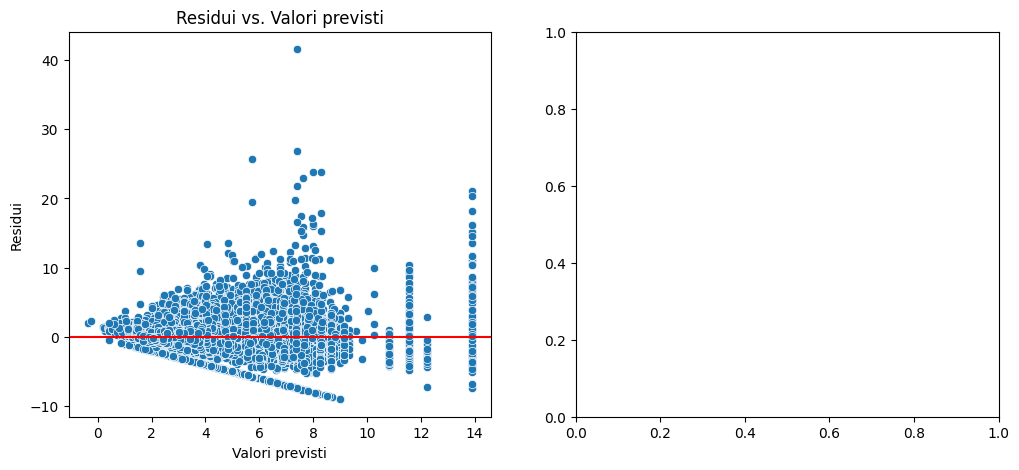

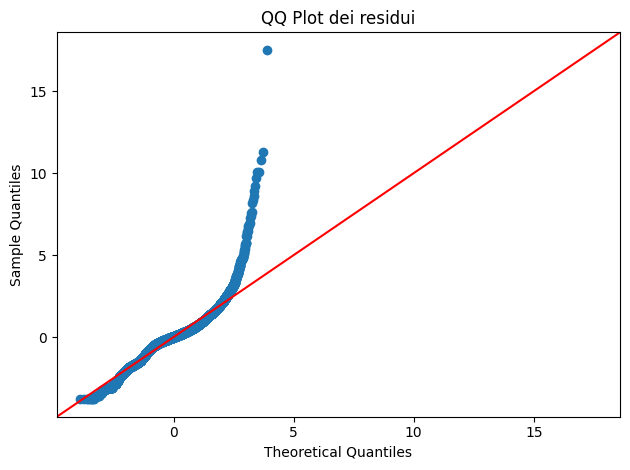

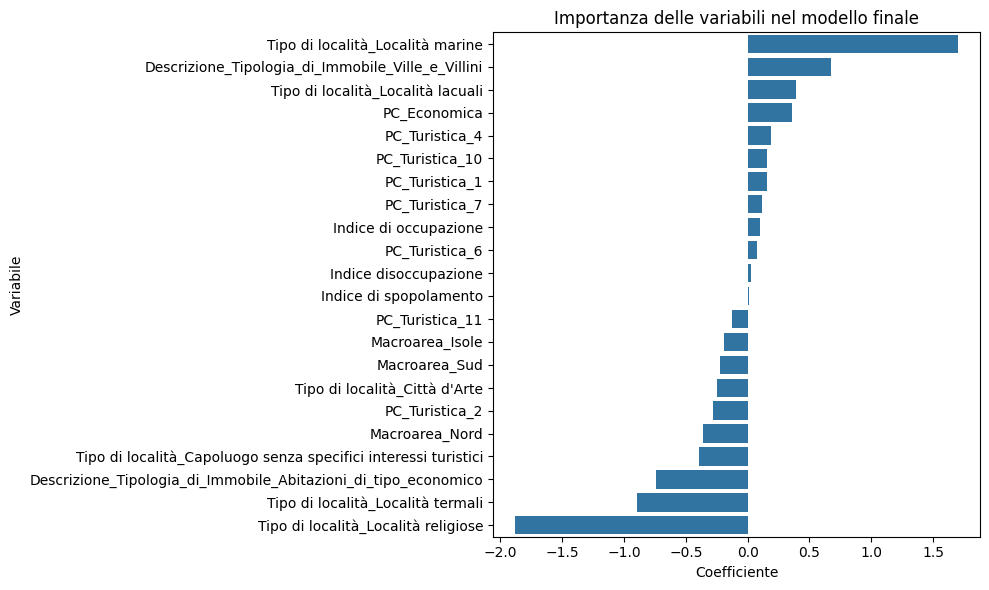

In [10]:
# 8. Predizione
def predici(model, X_test, selected_features):
    X_test_const = sm.add_constant(X_test[selected_features])
    return model.predict(X_test_const)

# Esecuzione dell'analisi
model, selected_features, X, y = esegui_analisi(df)

## Grafico 1: Residui vs. Valori Previsti
Questo grafico mostra la relazione tra i valori previsti dal modello e i residui (la differenza tra valori reali e valori previsti).
Osservazioni chiave:
- I residui non sono distribuiti in modo perfettamente casuale attorno alla linea dello zero (la linea rossa orizzontale).
- Si nota un pattern leggermente a forma di ventaglio, con residui che tendono ad aumentare in variabilità man mano che i valori previsti crescono.
- Ci sono alcuni residui positivi particolarmente elevati (punti nella parte superiore del grafico), suggerendo che il modello sottostima alcuni valori alti.
- Ci sono cluster di punti in corrispondenza di alcuni valori specifici (ad esempio intorno ai valori 10-14), suggerendo possibili variabili categoriche o relazioni non lineari.

Interpretazione: 
Questo pattern indica una leggera eteroschedasticità, cioè la varianza dei residui non è costante. In termini pratici, significa che il modello è meno preciso nelle previsioni per i valori più alti di "Media Costo alla Locazione". Potrebbe essere utile considerare una trasformazione della variabile target (ad esempio logaritmica) in future analisi.

## Grafico 2: QQ Plot dei Residui
Questo grafico confronta la distribuzione dei residui con una distribuzione normale teorica.
Osservazioni chiave:
-I punti dovrebbero idealmente seguire la linea rossa in diagonale.
- Si nota una significativa deviazione dalla normalità, specialmente nella coda superiore.
- La curva forma una "S", con i residui che si discostano dalla normalità sia per valori molto bassi che molto alti.

Interpretazione: 
Questo indica che i residui non seguono una distribuzione normale, una delle assunzioni base della regressione lineare. La forte deviazione nella parte superiore del grafico indica la presenza di outlier o di una distribuzione asimmetrica dei residui con coda pesante. Questo conferma l'osservazione del primo grafico e rafforza l'idea che una trasformazione della variabile target potrebbe migliorare il modello.

## Grafico 3: Importanza delle Variabili nel Modello Finale
Questo grafico mostra i coefficienti delle variabili selezionate dal processo stepwise, ordinati per importanza.
Osservazioni chiave:
-Le variabili con coefficienti positivi (barre verso destra) aumentano il costo di locazione.
- Le variabili con coefficienti negativi (barre verso sinistra) riducono il costo di locazione.
- "Tipo di località_Località marine" ha il maggior impatto positivo sul costo.
- "Tipo di località_Località religiose" ha un forte impatto negativo.

Interpretazione:
Le proprietà in località marine sono associate a costi di locazione significativamente più alti.
Le ville e i villini hanno anche loro un impatto positivo rilevante.
Le proprietà in località con carattere religioso tendono ad avere costi più bassi.
Le località termali mostrano anche loro un impatto negativo.
Diverse componenti principali turistiche (PC_Turistica_X) hanno effetti di varia entità, suggerendo che diversi tipi di attrattività turistica influenzano il costo in modi differenti.